 #  <center> Ψηφιακή Επεξεργασία Σημάτων </center>

## <center> 3η Εργαστηριακή Άσκηση </center>

<center> Αλβανάκη Ελισάβετ Λυδία, Α.Μ.: 03118167, email: ellialvanaki@gmail.com <br>
    Μουσάδη Δέσποινα, Α.Μ.: 03118108, email: despinan0@gmail.com </center>

# Κωδικοποίηση σημάτων Μουσικής βάσει του ψυχοακουστικού μοντέλου (Perceptual Audio Coding)

Αρχικά φορτώνουμε το απόσπασμα μουσικής:

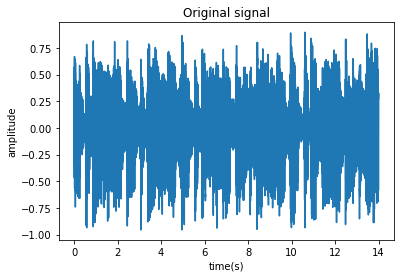

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

signal, fs = librosa.load("./DSP21_Lab3_material/dsp21_lab3_material/music.wav", sr = 44100)
t = np.linspace(0,14,len(signal))
plt.figure()
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("Original signal")
plt.plot(t,signal)
plt.show()

## Μέρος 1. Ψυχοακουστικό Μοντέλο 1

### Βήμα 1.0: Κανονικοποίηση του σήματος

Κανονικοποιούμε το σήμα διαιρώντας το με τη μέγιστη απόλυτη τιμή του, ώστε να παίρνει τιμές στο [-1,1].

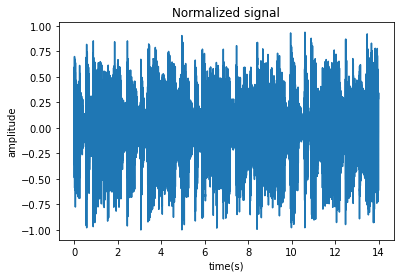

In [3]:
#normalization
max_abs = max(abs(signal))
#print(max_abs)
signal = signal/max_abs
plt.figure()
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("Normalized signal")
plt.plot(t,signal)
plt.show()

Έπειτα, για να πραγματοποιήσουμε την ανάλυση, χωρίζουμε το σήμα σε πλαίσια μήκους 512 δειγμάτων. Ενδεικτικά, αναπαριστούμε τα πλαίσια 50 και 500.

512


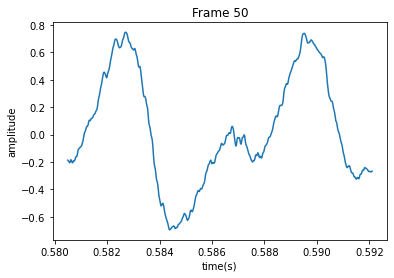

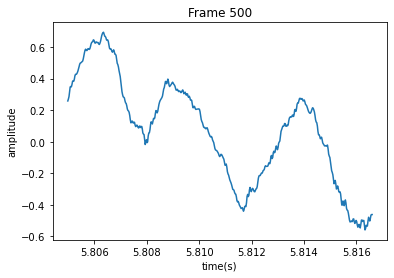

In [4]:
#splitting in frames of 512 samples

N=512
nr_of_frames = len(signal)//N
# print(nr_of_frames)
# print(len(signal))
# print(len(signal)/nr_of_frames)

frames = []
for i in range(nr_of_frames):
    frames.append(signal[N*i:(i+1)*N])
    
#print(len(frames))

#using frames 50 and 500 to check


print(len(frames[50]))
t50 = np.linspace(50*N/fs,51*N/fs,len(frames[50]))
plt.figure()
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("Frame 50")
plt.plot(t50,frames[50])
plt.show()
t500 = np.linspace(500*N/fs,501*N/fs,len(frames[500]))
plt.figure()
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.title("Frame 500")
plt.plot(t500,frames[500])

    

Επίσης, ορίζουμε μια συνάρτηση που υπολογίζει την κλίμακα Bark για δοσμένη συχνότητα.

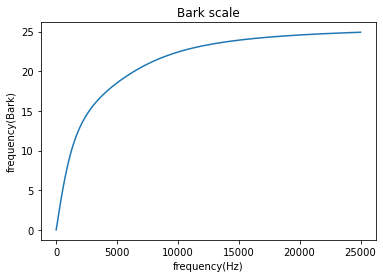

In [7]:
#bark scale

def bark_scale(f):
    b = 13*np.arctan(0.00076*f) + 3.5*np.arctan(pow((f/7500),2))
    return b

f = np.linspace(0, 2.5*pow(10,4), 2*pow(10,4))

plt.figure()
plt.xlabel("frequency(Hz)")
plt.ylabel("frequency(Bark)")
plt.title("Bark scale")
plt.plot(f,bark_scale(f))
plt.show()

Υπολογίζουμε την κλίμακα Bark στις συχνότητες όπου θα έχουμε τιμές του μετασχηματισμού Fourier και ορίζουμε ένα παράθυρο Hanning:

In [8]:
fft_length = N
#determining the frequencies, we keep N/2 frequencies because fft is symmetrical
fft_freqs = np.linspace(fs/fft_length,fs/2,fft_length//2)
bark = bark_scale(fft_freqs)

window = np.hanning(fft_length)



### Βήμα 1.1: Φασματική Ανάλυση

Βρίσκουμε το φάσμα ισχύος του σήματος:

In [9]:
def p_k (signal,window):
    pn = 90.302
    pk = pn + 10*np.log10(pow(abs(np.fft.fft(window*signal,fft_length)),2))
    return pk[:fft_length//2]

Αναπαριστούμε τα φάσματα των πλαισίων 50 και 500 σε συχνότητες στις κλίμακες Hz και Bark:

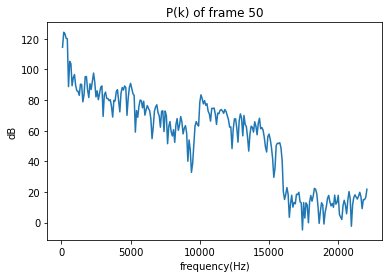

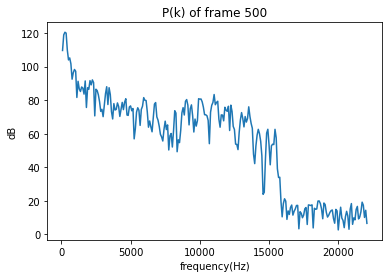

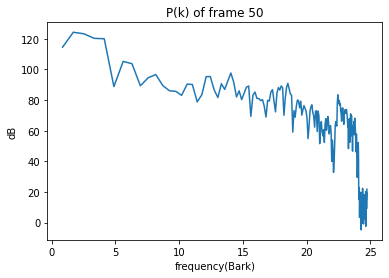

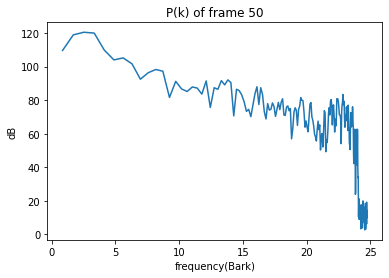

In [10]:
frame_p_k = []
for i in range(nr_of_frames):
    frame_p_k.append(p_k(frames[i],window))
    
plt.plot(fft_freqs,frame_p_k[50])
plt.title("P(k) of frame 50")
plt.xlabel("frequency(Hz)")
plt.ylabel("dB")
plt.show()

plt.plot(fft_freqs,frame_p_k[500])
plt.title("P(k) of frame 500")
plt.xlabel("frequency(Hz)")
plt.ylabel("dB")
plt.show()

plt.plot(bark,frame_p_k[50])
plt.title("P(k) of frame 50")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")
plt.show()
plt.plot(bark,frame_p_k[500])
plt.title("P(k) of frame 50")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")
plt.show()

### Βήμα 1.2: Εντοπισμός μασκών τόνων και θορύβου (Maskers)

Ορίζουμε τις συναρτήσεις St, Δκ και βρίσκουμε τις μάσκες τόνων του σήματος.

In [11]:
def delta_k(k):
    if (2<k and k<63):
        return [2,2]
    elif (63<=k and k<127):
        return [2,3]
    elif (127<=k and k<=250):
        return [2,6]
    return []

def st_k(p_k):
    st_k = np.zeros(fft_length//2)
    for i in range(3,251):
        if (p_k[i]>p_k[i+1] and p_k[i]>p_k[i-1]):
            b = 1 
            dk=delta_k(i)
            for j in range(len(dk)):
                t1 = i+dk[j]
                t2 = i-dk[j]
                if (t1>255 or t2 < 0 ): 
                    b=0
                    
                elif (p_k[i]<=p_k[i+dk[j]]+7 or p_k[i]<=p_k[i-dk[j]]+7):
                    b = 0
            st_k[i]=(b)   
    return st_k
            
            
def tone_maskers(p_k):
    st = st_k(p_k)
    #print(len(st))
    p_tm = []
    for i in range(len(st)):
        if (st[i]==1):
            p = 10*np.log10(10**(0.1*p_k[i-1])+10**(0.1*p_k[i])+10**(0.1*p_k[i+1]))
            p_tm.append(p)
        else: p_tm.append(0)
                                                   
    return p_tm

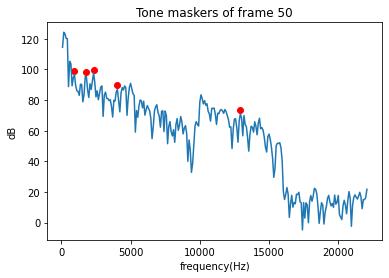

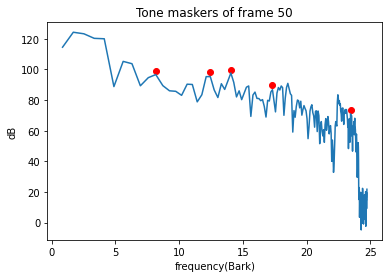

In [13]:
frame_p_tm = []
for i in range(nr_of_frames):
    frame_p_tm.append(tone_maskers(frame_p_k[i]))
    
plt.plot(fft_freqs,frame_p_k[50])
#plt.plot(fft_freqs,frame_p_tm[50]) 
y1= []  #ignoring zero values
for i in frame_p_tm[50]:
        if i == 0:
            i = None
        y1.append(i)
        
plt.title("Tone maskers of frame 50")
plt.xlabel("frequency(Hz)")
plt.ylabel("dB")
plt.scatter(fft_freqs,y1,color="r")
plt.show()

plt.plot(bark,frame_p_k[50])
plt.title("Tone maskers of frame 50")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")
plt.scatter(bark,y1,color="r")
plt.show()

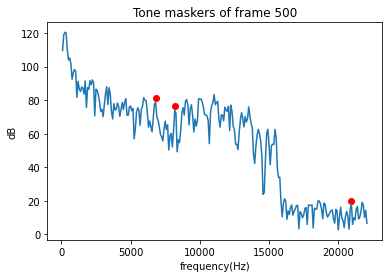

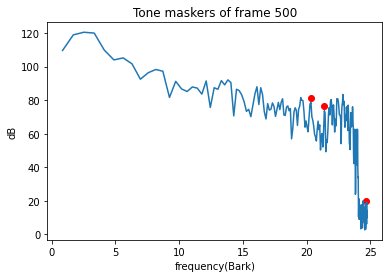

In [15]:
plt.plot(fft_freqs,frame_p_k[500])

y2= []
for i in frame_p_tm[500]:
        if i == 0:
            i = None
        y2.append(i)
        
plt.scatter(fft_freqs,y2,color="r") 
plt.title("Tone maskers of frame 500")
plt.xlabel("frequency(Hz)")
plt.ylabel("dB")
plt.show()

#print(len(frame_p_tm[500]))
plt.plot(bark,frame_p_k[500])
plt.scatter(bark,y2,color="r")
plt.title("Tone maskers of frame 500")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")
plt.show()


Διαβάζουμε τον δοσμένο πίνακα για τις μάσκες θορύβου:

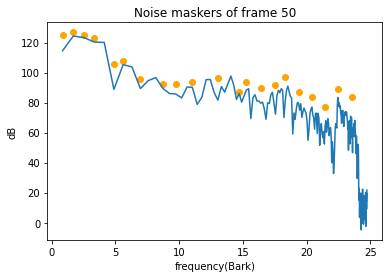

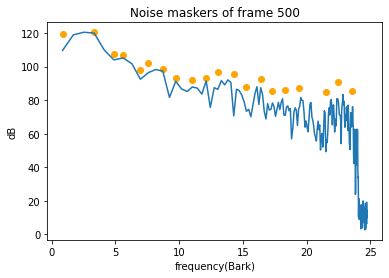

In [16]:
noise_maskers = np.load("./DSP21_Lab3_material/dsp21_lab3_material/P_NM.npy")
noise_maskers = np.transpose(noise_maskers)
# print(noise_maskers.shape[0])
# print(nr_of_frames)

y3= []
for i in noise_maskers[50]:
        
        if i == 0:
            i = None
        
        y3.append(i)

plt.scatter(bark,y3,color="orange")
plt.title("Noise maskers of frame 50")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")
plt.plot(bark,frame_p_k[50])

plt.show()

y4= []
for i in noise_maskers[500]:
        
        if i == 0:
            i = None
        
        y4.append(i)
plt.scatter(bark,y4,color="orange")
plt.title("Noise maskers of frame 500")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")
plt.plot(bark,frame_p_k[500])
    

Επίσης, υπολογίζουμε το κατώφλι ακοής σε dB SPL, ώστε να μπορούμε να το χρησιμοποιήσουμε στα επόμενα βήματα.

<function matplotlib.pyplot.show(close=None, block=None)>

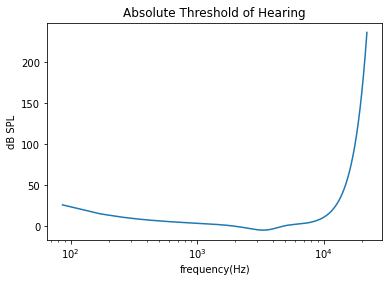

In [17]:
import math
threshold = 3.64*((fft_freqs/1000)**(-0.8)) - 6.5*np.exp(-0.6*((fft_freqs/1000-3.3)**2)) + (10**(-3))*((fft_freqs/1000)**4)

plt.xscale('log')

plt.plot(fft_freqs,threshold)
plt.title("Absolute Threshold of Hearing")
plt.xlabel("frequency(Hz)")
plt.ylabel("dB SPL")
plt.show



### Βήμα 1.3: Μείωση και αναδιοργάνωση των μασκών

Διαβάζουμε τους δοσμένους πίνακες μειωμένων μασκών τόνου και θορύβου:

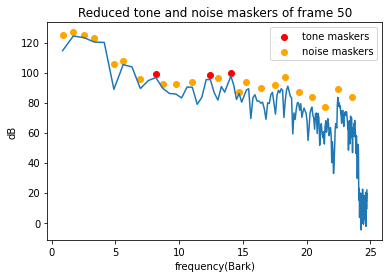

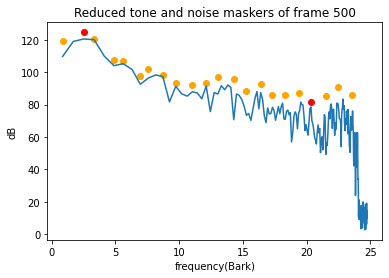

In [18]:
p_tmc = np.transpose(np.load("./DSP21_Lab3_material/dsp21_lab3_material/P_TMc.npy"))
p_nmc = np.transpose(np.load("./DSP21_Lab3_material/dsp21_lab3_material/P_NMc.npy"))

y5= []
for i in p_tmc[50]:
        
        if i == 0:
            i = None
        
        y5.append(i)

plt.scatter(bark,y5,color="red",label = "tone maskers")
plt.title("Reduced tone and noise maskers of frame 50")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")

y6= []
for i in p_nmc[50]:
        
        if i == 0:
            i = None
        
        y6.append(i)

plt.scatter(bark,y6,color="orange", label = "noise maskers")
plt.plot(bark,frame_p_k[50])
plt.legend()
plt.show()

y7= []
for i in p_tmc[500]:
        
        if i == 0:
            i = None
        
        y7.append(i)

plt.scatter(bark,y7,color="red", label = "tone maskers")
plt.title("Reduced tone and noise maskers of frame 500")
plt.xlabel("frequency(Bark)")
plt.ylabel("dB")

y8= []
for i in p_nmc[500]:
        
        if i == 0:
            i = None
        
        y8.append(i)

plt.scatter(bark,y8,color="orange", label = "noise maskers")
plt.plot(bark,frame_p_k[500])
plt.show()
plt.show()


### Βήμα 1.4: Υπολογισμός των δυο διαφορετικών κατωφλίων κάλυψης (Individual Masking Thresholds)


Ορίζουμε τις συναρτήσεις για τον υπολογισμό των διαφορετικών κατωφλιών κάλυψης:

In [19]:

#initializing

t_g = np.zeros((nr_of_frames,fft_length//2))



def find_tone_threshold(maskj, p_tm, b):

    bj = b[maskj]  #mask location in bark scale
    
    startbi = bj-3
    endbi = bj+8
#     print(startbi)
#     print(endbi)
   
    liststart = np.where(b<=startbi)
    
    if len(liststart[0])>1:
        startbi = liststart[0][len(liststart[0])-1]
    else: startbi = 1
    
    
   
    listend = np.where(b<=endbi)

    if len(listend[0])>1:
        endbi = listend[0][len(listend[0])-1]
    
    #calculating SF
    
    SF = np.zeros(endbi-startbi+1)
    for i in range(startbi,endbi):
        delta_b = b[i] - bj
        if (delta_b >= -3 and delta_b<-1):
            SF[i-startbi] = 17*delta_b - 0.4*p_tm + 11
        elif (delta_b >= -1 and delta_b < 0):
            SF[i-startbi] = (0.4*p_tm + 6)*delta_b
        elif (delta_b >= 0 and delta_b < 1):
            SF[i-startbi] = -17*delta_b
        elif (delta_b >= 1 and delta_b < 8.5):
            SF[i-startbi] = (0.15*p_tm - 17)*delta_b - 0.15*p_tm
            
    #calculating thresholds
    t_tm = np.zeros(fft_length//2)
    for i in range(startbi,endbi):
        t_tm[i-startbi] = p_tm - 0.275*bj + SF[i-startbi] - 6.025
    return t_tm  
        
        
    
    
    
    
    
def find_noise_threshold(maskj, p_nm, b):
    bj = b[maskj]  #mask location in bark scale
    
    startbi = bj-3
    endbi = bj+8

    liststart = np.where(b<=startbi)

    if len(liststart[0])>1:
        startbi = liststart[0][len(liststart[0])-1]
    else: startbi = 1
    
    

    listend = np.where(b<=endbi)

    if len(listend[0])>1:
        endbi = listend[0][len(listend[0])-1]
    
    
    SF = np.zeros(endbi-startbi+1)
    for i in range(startbi,endbi):
        delta_b = b[i] - bj
        if (delta_b >= -3 and delta_b<-1):
            SF[i-startbi] = 17*delta_b - 0.4*p_nm + 11
        elif (delta_b >= -1 and delta_b < 0):
            SF[i-startbi] = (0.4*p_nm + 6)*delta_b
        elif (delta_b >= 0 and delta_b < 1):
            SF[i-startbi] = -17*delta_b
        elif (delta_b >= 1 and delta_b < 8.5):
            SF[i-startbi] = (0.15*p_nm - 17)*delta_b - 0.15*p_nm
            
    #calculating thresholds
    t_nm = np.zeros(fft_length//2)
    for i in range(startbi,endbi):
        t_nm[i-startbi] = p_nm - 0.275*bj + SF[i-startbi] - 2.025
    
    return t_nm


### Βήμα 1.5: Υπολογισμός του συνολικού κατωφλίου κάλυψης (Global Masking Threshold)

Βρίσκουμε τα διαφορετικά κατώφλια κάλυψης και το συνολικό κατώφλι κάλυψης για κάθε πλαίσιο:

In [20]:


for i in range(nr_of_frames):
    
    tm_indices = np.where(p_tmc[i]>0)[0]
    
    nm_indices = np.where(p_nmc[i]>0)[0]
    
    t_tm = np.zeros((len(tm_indices),fft_length//2))
    

    t_nm = np.zeros((len(nm_indices),fft_length//2))


    for j in range(len(tm_indices)):
        
        t_tm[j][:] = find_tone_threshold(tm_indices[j], p_tmc[i][tm_indices[j]], bark)
        
        
    for j in range(len(nm_indices)):
        
        t_nm[j][:] = find_noise_threshold(nm_indices[j], p_nmc[i][nm_indices[j]], bark)
        

    t_tm = t_tm.transpose()
    t_nm = t_nm.transpose()

    
    for j in range(fft_length//2):
       
        val = 10*np.log10(10**(0.1*threshold[j]) + np.sum(10**(0.1*t_tm[j])) + np.sum(10**(0.1*t_tm[j])))
        t_g[i][j] = (val)
        


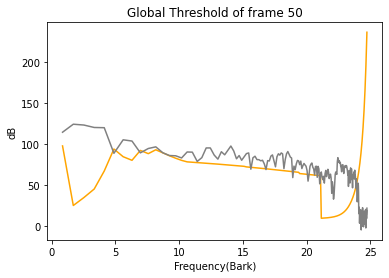

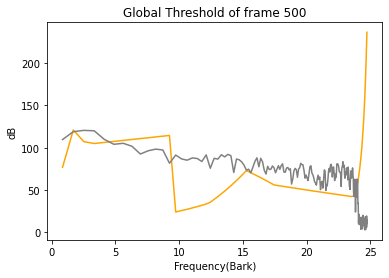

In [21]:

plt.plot(bark,t_g[50], color = "orange")
plt.plot(bark,frame_p_k[50], color = "grey")
plt.title("Global Threshold of frame 50")
plt.xlabel("Frequency(Bark)")
plt.ylabel("dB")
plt.show()

plt.plot(bark,t_g[500], color = "orange")
plt.plot(bark,frame_p_k[500], color = "grey")
plt.title("Global Threshold of frame 500")
plt.xlabel("Frequency(Bark)")
plt.ylabel("dB")
plt.show()


## Μέρος 2. Χρονο-Συχνοτική Ανάλυση με Συστοιχία Ζωνοπερατών Φίλτρων

Αρχικά ορίζουμε τα φίλτρα ανάλυσης hk και σύνθεσης gk:

In [22]:
#part 2
#2.0 
#defining filters
M = 32
L = 2*M
h_kn = np.zeros((M,L))
g_kn = np.zeros((M,L))
for k in range(M):
    for n in range(L):
        h_kn[k][n] = np.sin((n+1/2)*np.pi/(2*M)) * np.sqrt(2/M) * np.cos((2*n+M+1)*(2*k+1)*np.pi/(4*M))
for k in range(M):
    for n in range(L):
        g_kn[k][n] = h_kn[k][2*M-1-n]
    


Ακολουθούμε τη διαδικασία των βημάτων 2.1, 2.2 και 2.3. Πιο συγκεκριμένα, για κάθε πλαίσιο εφαρμόζουμε τα εξής: 
1. συνέλιξη με το φίλτρο hk και αποδεκατισμός
2. κβαντοποίηση
3. υπερδειγματοληψία των κβαντισμένων ακολουθιών και συνέλιξη με τα φίλτρα σύνθεσης

Αρχικά εκτελούμε την ανάλυση χρησιμοποιώντας έναν προσασμοζόμενο ομοιόμορφο κβαντιστή, στον οποίο τα επίπεδα κβάντισης εξαρτώνται από το εκάστοτε συνολικό κατώφλι.

In [23]:

import scipy



#ADAPTIVE QUANTIZER
R = 2**16 #16 bits/sample
output = np.zeros((nr_of_frames,fft_length+L-1//M + L-1))
overall_bits = 0
for fr in range(nr_of_frames):
    
    #print("frame is" + str(fr))
    v_k = np.zeros((M,fft_length+L-1))
    y_k = np.zeros((M,(fft_length+L-1)//M + 1))
    yquant = np.zeros((M,(fft_length+L-1)//M + 1))
    bits = 0
    
    for k in range(1,M+1):
        
        #2.1
        v_k[k-1] = np.convolve(h_kn[k-1],frames[fr])
        #downsampling
        y_k[k-1] = scipy.signal.decimate(v_k[k-1],M) 
    
    
    #2.2 quantization
        #16 indices around k
        #finding min tg

        tg_min = min(abs(t_g[fr][8*(k-1):8*(k+1)]))

        #finding b_k
        #print("k is"+str(k))
        b = np.log2(R/abs(tg_min)-1)

        b_k = int(b)
        
        maxyk = max(y_k[k-1])
        minyk = min(y_k[k-1])
        
        bits += b_k*len(y_k[k-1])
        
        delta = abs(maxyk-minyk)/2**b_k
        
        
        
        for i in range(len(y_k[k-1])):
            val = int(y_k[k-1][i]-minyk/delta)
            if val == 2**b_k:
                val -= 1
            
            yquant[k-1][i] = delta*(val+1/2)+minyk
        
            
            
        #2.3 synthesis
        
        w_k = scipy.signal.resample(yquant[k-1],len(yquant[k-1])*M)
        
#         print(len(g_kn[k]))
#         print(len(w_k))
        outg_k = 10*np.convolve(g_kn[k-1],w_k,'full')
#         print(len(outg_k))
        output[fr] = output[fr] + outg_k
        
    overall_bits += bits

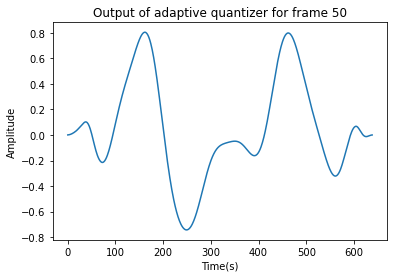

In [24]:
plt.plot(output[50])
plt.title("Output of adaptive quantizer for frame 50")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

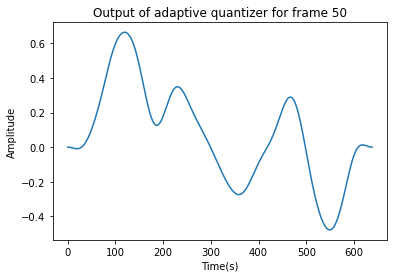

In [25]:
plt.plot(output[500])
plt.title("Output of adaptive quantizer for frame 50")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

Ανακατασκευάζουμε το σήμα μουσικής χρησιμοποιώντας την τεχνική Overlap-add.

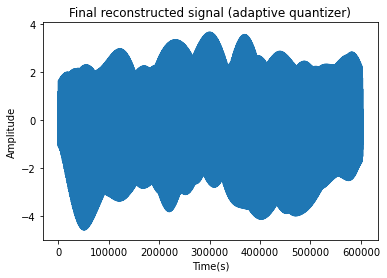

In [27]:
#final reconstruction of signal using overlap-add method
L_rec = fft_length+L-1//M + L-1

R_rec = fft_length


#filters add 2M samples in the beginning and end of output
output1 = np.zeros((nr_of_frames,L_rec-4*M+1))
for fr in range(len(output)):
    output1[fr] = (output[fr][2*M:L_rec-2*M+1])
#output1 = output[64:575][:]


k = 0
rec_signal = np.zeros(nr_of_frames*(L_rec-4*M+1))

for j in range(L_rec-4*M+1):
    for i in range(nr_of_frames):
        rec_signal[k] += output1[i][j]
        k=k+1
rec_signal = rec_signal[:len(signal)]

plt.plot(rec_signal)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Final reconstructed signal (adaptive quantizer)")
plt.show()
    



Τώρα χρησιμοποιούμε έναν 8-bit κβαντιστή (εδώ ο αριθμός bits κωδικοποίησης είναι σταθερός και ανεξάρτητος του κατωφλιού). 

In [28]:
#8-bit quantizer
#same process

output_8bit = np.zeros((nr_of_frames,fft_length+L-1//M + L-1))
overall_bits = 0
for fr in range(nr_of_frames):
    #print("frame is" + str(fr))
    v_k = np.zeros((M,fft_length+L-1))
    y_k = np.zeros((M,(fft_length+L-1)//M + 1))
    yquant = np.zeros((M,(fft_length+L-1)//M + 1))
    bits = 0
    
    for k in range(M):
        
        #2.1
        v_k[k] = np.convolve(h_kn[k],frames[fr])
        #downsampling
        y_k[k] = scipy.signal.decimate(v_k[k],M) 
    
    
    #2.2 quantization
        
        b_k = int(8)
        
        maxyk = 1
        minyk = -1
        
        bits += b_k*len(y_k[k])
        
        delta = abs(maxyk-minyk)/2**b_k
        
        
        
        for i in range(len(y_k[k])):
            val = int(y_k[k][i]-minyk/delta)
            if val == 2**b_k:
                val -= 1
            
            yquant[k][i] = delta*(val+1/2)+minyk
        
            
            
        #2.3 synthesis
        
        w_k = scipy.signal.resample(yquant[k],len(yquant[k])*M)
        
#         print(len(g_kn[k]))
#         print(len(w_k))
        outg_k = 10*np.convolve(g_kn[k],w_k,'full')
#         print(len(outg_k))
        output_8bit[fr] = output_8bit[fr] + outg_k
    overall_bits += bits

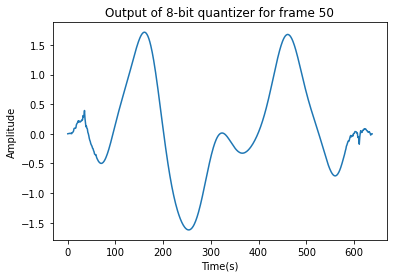

In [29]:
plt.plot(output_8bit[50])
plt.title("Output of 8-bit quantizer for frame 50")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

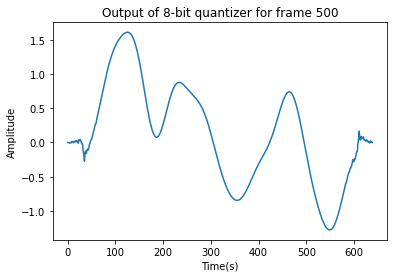

In [30]:
plt.plot(output_8bit[500])
plt.title("Output of 8-bit quantizer for frame 500")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

Παρατηρούμε ότι με προσαρμοζόμενο κβαντιστή, το κβαντισμένο σήμα είναι πιο κοντά στο αρχικό.

Τέλος, παίρνουμε το τελικό ανακατασκευασμένο σήμα μέσω της μεθόδου overlap-add.

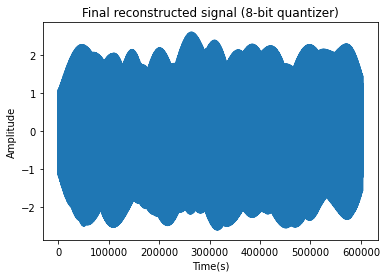

In [32]:
output2 = np.zeros((nr_of_frames,L_rec-4*M+1))
for fr in range(len(output_8bit)):
    output2[fr] = (output_8bit[fr][2*M:L_rec-2*M+1])
#output1 = output[64:575][:]


k = 0
rec_signal_8bit = np.zeros(nr_of_frames*(L_rec-4*M+1))

for j in range(L_rec-4*M+1):
    for i in range(nr_of_frames):
        rec_signal_8bit[k] += output2[i][j]
        k=k+1
rec_signal_8bit = rec_signal_8bit[:len(signal)]

plt.plot(rec_signal_8bit)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Final reconstructed signal (8-bit quantizer)")
plt.show()

Τέλος, αποθηκεύουμε τα δύο σήματα που προέκυψαν για τον προσαρμοζόμενο και τον μην προσαρμοζόομενο κβαντιστή στα αρχεία adaptive.wav και 8bit.wav αντίστοιχα.

In [27]:
import soundfile as sf
sf.write('adaptive.wav', rec_signal, 44100)
sf.write('8bit.wav', rec_signal_8bit, 44100)